In [1]:
import numpy as np 
import pandas as pd
import matplotlib.pylab as plt 
import jax.numpy as jnp 
# import numpyro 
# from getdist import plots, MCSamples
# import getdist
import glob
import astropy.units as u
import astropy.constants as con
from scipy.integrate import quad
import numpyro
import numpyro.distributions as dist
from numpyro.infer import MCMC, NUTS, init_to_median

In [2]:
data = pd.read_csv("data/jla_lcparams.txt", sep=" ", header=0)
covariance = np.load("data/covariance.npz")['arr_0'] 

In [3]:
columns = ['zcmb', 'mb', 'dmb', '3rdvar', 'x1', 'color']
data_filtered = data[columns]
data_filtered.columns = ['z', 'mb', 'delta_M', 'M_stel', 'X1', 'C']
inputs = data_filtered[["z", "M_stel", "X1", "C"]].values

In [4]:
zs = data_filtered['z']
mb = data_filtered['mb']
delta_M = data_filtered['delta_M']
M_stel = data_filtered['M_stel']
X1 = data_filtered['X1']
C = data_filtered['C']

#mb is peak magnitude
#zcmb is redshift
#3rdvar is log10 host stellar mass
#x1 is SALT2 shape parameter
#color is color parameter

In [5]:
# z_arr = np.asarray(data_filtered['z'])
# mb_arr = np.asarray(mb)
# delta_M_arr = np.asarray(delta_M)
# Mstel_arr = np.asarray(M_stel)*10**10
# X1_arr = np.asarray(X1)
# C_arr = np.asarray(C)

In [6]:
# If M_Stel is greater than 10^10 Msun, then the Heaviside function is 1.
# If M_stel is less than 10^10 Msun, then it's 0.

In [7]:
def heavyside(M_stel):
    SM10 = 10
    return jnp.where(M_stel<SM10,0,1)

def absfunc(M_stel, hev_f, M_B, delta_m):
    #modified_M_B = M_B + delta_m * (M_stel - SM10)
    #modified_M_B = M_B + delta_m * (M_stel.to(u.Msun).value - SM10.value)
    return modified_M_B

In [8]:
def hgalaxy(M_stel,M_B, delta_m):
    SM10=10**10
    #The absolute magnitude is dependent on properties of the hgalaxy
    hev_f=heavyside(M_stel)
    absmag = M_B + delta_m * hev_f 
    return absmag

In [9]:
def integrand(z,Om_m, w0):
        p1 = (1 + z)**3
        p2 = (1 - Om_m)
        p3 = (Om_m * p1) + p2 * (p1)**(3*(w0 + 1))
        squared = jnp.sqrt(p3)
        return 1 / squared   #returns the value of the integrand
    
def D_L(z,Om_m=0.315,w0=-1,H0=70,num=800):
    coeff=10**5 * (1.0 + z) * 299792.458 / H0
    
    z1 = jnp.linspace(0, z, num=num)
    y = integrand(z1,Om_m,w0)
    
    integral=jnp.trapezoid(y, z1)
    return coeff*integral

In [10]:
def main(Om_m, z, w0, M_B, M_stel, delta_m, alpha, beta, X1, C):  #Making a function that takes in values for these parameters

    Lum_dist = D_L(z,Om_m, w0) #Using Luminosity distance function in main, which uses integrand inside

    hev_f=heavyside(M_stel)
    pt1 = 5*jnp.log10((Lum_dist)/10)      #5log10D*L/10pc
    pt2 = hgalaxy(M_stel, M_B, delta_m)         #This should give the return of absfunc which is modified_M_B
    # pt3 = ((alpha * X1) + (beta * C))                  #Last part of the equation
    
    app_mag = pt1 + pt2 - (alpha*X1) +(beta*C)    #Putting it all together
    
    return app_mag

In [11]:
#main(Om_m, z, w0, M_B, M_stel, absmag, alpha, beta, X1, C): 
Om_m = 0.315
w0 = -1
# M_stel = 19.3
alpha = 0.1257
beta = 2.644
M_B = -19.3
delta_m = -0.061
SM10=10**10

In [12]:
main(Om_m, zs[1], w0, M_B, M_stel[1], delta_m, alpha, beta, X1[1], C[1])

Array(18.151533, dtype=float32)

In [13]:
mB_final= 5*np.log10((D_L(zs[1],Om_m,w0))/10) + hgalaxy(M_stel[1],M_B,delta_m)-(alpha*X1[1])+(beta*C[1])
mB_final

Array(18.151537, dtype=float32)

In [14]:
z = 0.5
D_L_value = D_L(z)
# print(f"D_L(z={z}) = {D_L_value}, Units = {D_L_value.unit}")
D_L(z)

Array(2.8183603e+08, dtype=float32)

In [15]:
df = pd.DataFrame(columns=['magnitude'])

for i in range (len(zs)):
    # D_L_value = D_L(z_arr[i])
    # D_L_value_in_parsecs = D_L_value.to(u.pc).value

    finalvals=main(Om_m, zs[i], w0, M_B, M_stel[i], delta_m, alpha, beta, X1[i], C[i])
    
    # # calculating the apparent magnitude
    # mB_finalvals = 5 * np.log10((D_L_value_in_parsecs * 10**6)/ 10)
    #mB_finalvals = 5 * np.log10(D_L_value * 10**6 / 10)
    new_row = {'magnitude': finalvals}
    df.loc[len(df)] = new_row
#print(mb_arr)


In [16]:
columns = ['zcmb', 'mb', 'dmb', '3rdvar', 'x1', 'color']
data_filtered = data[columns]
data_filtered.columns = ['z', 'mb', 'delta_M', 'M_stel', 'X1', 'C']

z = data_filtered['z']
mb = data_filtered['mb']
delta_M = data_filtered['delta_M']
M_stel = data_filtered['M_stel']
X1 = data_filtered['X1']
C = data_filtered['C']


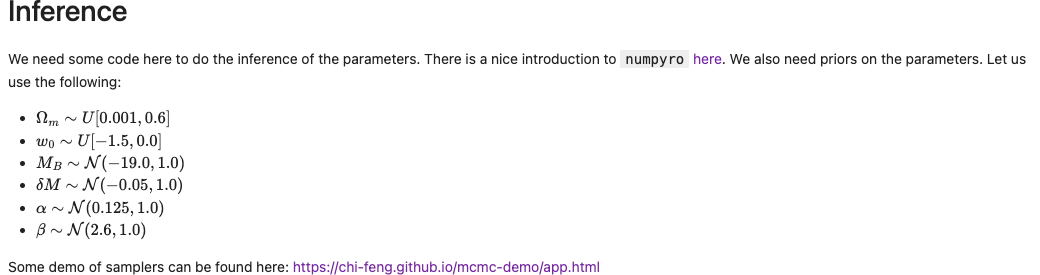

In [17]:
import jax
import jax.numpy as jnp
import numpyro
import numpyro.distributions as dist

def cosmology_model(data, cov_matrix, input_data):
    # Define priors for the cosmological parameters
    Omega_m = numpyro.sample('Omega_m', dist.Uniform(low=0.001, high=0.6))
    w0 = numpyro.sample('w_0', dist.Uniform(low=-1.5, high=0.0))
    
    # Define priors for the nuisance parameters
    M_B = numpyro.sample('M_B', dist.Normal(loc=-19.0, scale=1.0))
    delta_m = numpyro.sample('delta_M', dist.Normal(loc=-0.05, scale=1.0))
    alpha = numpyro.sample('alpha', dist.Normal(loc=0.125, scale=1.0))
    beta = numpyro.sample('beta', dist.Normal(loc=2.6, scale=1.0))

    # Combine cosmological and nuisance parameters into dictionaries for easy access
    cosmo_params = {
        'Omega_m': Omega_m,
        'w0': w0,
    }
    nuisance_params = {
        'M_B': M_B,
        'delta_m': delta_m,
        'alpha': alpha,
        'beta': beta,
    }

    # Function to compute theoretical predictions
    def calculate_magnitude(inputs):
        z, M_stel, X1, C = inputs
        # Extract parameters from dictionaries
        alpha = nuisance_params['alpha']
        beta = nuisance_params['beta']
        # Pass the parameters explicitly if required
        return main(cosmo_params['Omega_m'], z, cosmo_params['w0'], nuisance_params['M_B'], M_stel, nuisance_params['delta_m'], alpha, beta, X1, C)
    
    # Apply the calculation across the input data
    theoretical_values = jax.lax.map(calculate_magnitude, input_data)
    
    # Define the likelihood
    likelihood = dist.MultivariateNormal(loc=theoretical_values, covariance_matrix=cov_matrix)
    numpyro.sample("observed_magnitudes", likelihood, obs=data)


In [18]:
def cosmo_model(data, cov_matrix, input_data):
        # Define priors for the cosmological parameters
    Omega_m = numpyro.sample('Omega_m', dist.Uniform(low=0.001, high=0.6))
    w0 = numpyro.sample('w_0', dist.Uniform(low=-1.5, high=0.0))
    
    # Define priors for the nuisance parameters
    abs_mag = numpyro.sample('M_B', dist.Normal(loc=-19.0, scale=1.0))
    delta_m = numpyro.sample('delta_M', dist.Normal(loc=-0.05, scale=1.0))
    alpha = numpyro.sample('alpha', dist.Normal(loc=0.125, scale=1.0))
    beta = numpyro.sample('beta', dist.Normal(loc=2.6, scale=1.0))

    # Combine cosmological and nuisance parameters
    cosmo_params = (Omega_m, w0)
    nuisance_params = (abs_mag, delta_m, alpha, beta)

    # Function to compute theoretical predictions
    def calculate_magnitude(input_data):
        z, M_stel, X1, C = input_data
        alpha = cosmo_params['alpha']
        beta = cosmo_params['beta']
    # Pass the parameters explicitly if required
    return main(Omega_m,z,w0, abs_mag, M_stel, delta_m, alpha, beta, X1, C)
  
    theoretical_values = jax.lax.map(calculate_magnitude, input_data)
    
    # Define the likelihood
    likelihood = dist.MultivariateNormal(loc=theoretical_values, covariance_matrix=cov_matrix)
    numpyro.sample("observed_magnitudes", likelihood, obs=data)

In [34]:
NWARMUP = 100
NSAMPLES = 10000
EPS = 0.1
NCHAIN = 2
TREE_DEPTH = 5 

In [35]:
nuts_kernel = NUTS(cosmology_model, step_size=EPS, init_strategy=init_to_median, dense_mass=True, max_tree_depth=TREE_DEPTH)

In [36]:
import jax
from jax import random
from numpyro.infer import MCMC, NUTS

In [22]:
mcmc_nuts = MCMC(nuts_kernel, 
                 num_warmup=NWARMUP, 
                 num_samples=NSAMPLES, 
                 num_chains=NCHAIN, 
                 chain_method="vectorized",
                 progress_bar=True)

In [23]:
mcmc_nuts.run(jax.random.PRNGKey(253), data_filtered['mb'].values, covariance, inputs)

sample: 100%|██████████| 110/110 [05:56<00:00,  3.24s/it]


In [27]:
print(samples.keys())

dict_keys(['M_B', 'Omega_m', 'alpha', 'beta', 'delta_M', 'w_0'])


In [29]:
from getdist import plots, MCSamples
from matplotlib import cm 
import getdist 

color1 = "#50C878" 

# settings for plotting
settings = {'mult_bias_correction_order': 0, 'smooth_scale_2D': 0.3, 'smooth_scale_1D': 0.3}

samples = mcmc_nuts.get_samples()

columns = ['M_B', 'Omega_m', 'alpha', 'beta', 'delta_M', 'w_0']

# convert the samples to a 2D numpy array
mcmc_samples = np.vstack([samples[c] for c in columns]).T

# number of dimensions (parameters)
ndim = len(columns)

# names and labels for the parameters
names = ["x%s" % i for i in range(ndim)]
labels = [
    r"$\Omega_{m}$",
    r"$w_{0}$",
    r"$M$",
    r"$\delta M$",
    r"$\alpha$",
    r"$\beta$"]

# create getdist samples object
getdist_samples = MCSamples(samples=mcmc_samples, names=names, labels=labels, ranges={'x0': (0.0, None)}, label='JLA (NUTS)', settings=settings)


Removed no burn in


In [30]:
G = plots.getSubplotPlotter(subplot_size=1.25)
G.settings.solid_contour_palefactor = 0.9
G.settings.alpha_filled_add = 0.5
G.settings.num_plot_contours = 2
G.settings.lw_contour = 1
G.settings.axes_fontsize = 15
G.settings.lab_fontsize = 15
G.settings.fontsize = 35  
G.settings.legend_fontsize = 15
getdist_samples.updateSettings({"contours": [0.68, 0.95]})
G.triangle_plot([getdist_samples],
    filled=[True],
    contour_colors=[color1],
    contour_lws=[2],
    contour_ls=["-"],
)
# plt.savefig('triangle_plot_jla_nuts.pdf', transparent = False, bbox_inches = 'tight')
plt.show()

MCSamplesError: Parameter range is <= 0: x0